In [1]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import sys
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


# remove warnings
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pandas.io.formats.format')

# 1. Loading Dataset

In [2]:
# Loading the data
new_data = pd.read_csv("/kaggle/input/seperated-data/Pakistan_Lahore.csv")

# print the shape
print(new_data.shape)

#runs the first 5 rows
new_data.head()

(1570, 12)


,Date,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
0,2019-05-09,NaN,NaN,NaN,NaN,196.0,NaN,20.0,1003.0,33.0,2.3,Pakistan_Lahore
1,2019-05-10,NaN,NaN,NaN,NaN,159.0,NaN,28.0,1004.0,32.0,3.6,Pakistan_Lahore
2,2019-05-11,NaN,NaN,NaN,NaN,197.0,NaN,43.0,1007.0,29.0,3.0,Pakistan_Lahore
3,2019-05-12,NaN,NaN,NaN,NaN,176.0,NaN,37.0,1006.0,31.0,2.5,Pakistan_Lahore
4,2019-05-13,NaN,NaN,NaN,NaN,171.0,NaN,51.0,1005.0,28.0,2.5,Pakistan_Lahore


In [3]:
# Find the minimum and maximum dates
min_date = new_data['Date'].min()
max_date = new_data['Date'].max()

print('Minimum date:', min_date)
print('Maximum date:', max_date)

Minimum date: 2019-05-09
Maximum date: 2025-01-09


In [4]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1570 non-null   object 
 1   co            0 non-null      float64
 2   no2           0 non-null      float64
 3   o3            0 non-null      float64
 4   pm10          0 non-null      float64
 5   pm25          1570 non-null   float64
 6   so2           0 non-null      float64
 7   humidity      1546 non-null   float64
 8   pressure      1546 non-null   float64
 9   temperature   1546 non-null   float64
 10  wind-speed    1452 non-null   float64
 11  Country_City  1570 non-null   object 
dtypes: float64(10), object(2)
memory usage: 147.3+ KB


In [5]:
new_data.describe()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed
count,0.0,0.0,0.0,0.0,1570.000000,0.0,1546.000000,1546.000000,1546.000000,1452.000000
mean,NaN,NaN,NaN,NaN,177.652229,NaN,60.527814,1008.290944,24.336869,2.848829
std,NaN,NaN,NaN,NaN,83.876598,NaN,16.844766,7.182917,8.097599,1.260782
min,NaN,NaN,NaN,NaN,5.000000,NaN,18.000000,992.000000,6.000000,0.500000
25%,NaN,NaN,NaN,NaN,127.000000,NaN,50.000000,1002.000000,18.000000,2.000000
50%,NaN,NaN,NaN,NaN,159.000000,NaN,62.000000,1008.000000,26.500000,2.500000
75%,NaN,NaN,NaN,NaN,196.000000,NaN,72.000000,1015.000000,30.500000,3.600000
max,NaN,NaN,NaN,NaN,568.000000,NaN,100.000000,1024.000000,39.000000,8.700000


In [6]:
# Investigate all the elements whithin each Feature

for column in new_data:
    # Handle numerical and string columns differently
    if new_data[column].dtype == 'object':  # Check if column is of object type
        unique_vals = new_data[column].unique()  # pandas unique for strings
    else:
        unique_vals = np.unique(new_data[column])  # numpy unique for numerical types

    nr_values = len(unique_vals)
    if nr_values < 14:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Date :1569
The number of values for feature co :1 -- [nan]
The number of values for feature no2 :1 -- [nan]
The number of values for feature o3 :1 -- [nan]
The number of values for feature pm10 :1 -- [nan]
The number of values for feature pm25 :324
The number of values for feature so2 :1 -- [nan]
The number of values for feature humidity :153
The number of values for feature pressure :76
The number of values for feature temperature :78
The number of values for feature wind-speed :41
The number of values for feature Country_City :1 -- ['Pakistan_Lahore']


In [7]:
new_data.isna().sum()

Date               0
co              1570
no2             1570
o3              1570
pm10            1570
pm25               0
so2             1570
humidity          24
pressure          24
temperature       24
wind-speed       118
Country_City       0
dtype: int64

# 1.2 - Function -- Preprocessing

In [8]:
print(os.listdir('/kaggle/usr/lib/function_v'))

['function_v.py', '__results__.html', '__notebook__.ipynb', '__output__.json', 'custom.css']


In [9]:
sys.path.append("/kaggle/usr/lib/function_v")  # Add directory to the path

import function_v as fn

### Datetime index 

In [10]:
# Use the functions
new_data1 = fn.prepare_datetime_index(new_data, date_column='Date')
new_data1.head()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
Date,,,,,,,,,,,
2019-05-09,NaN,NaN,NaN,NaN,196.0,NaN,20.0,1003.0,33.0,2.3,Pakistan_Lahore
2019-05-10,NaN,NaN,NaN,NaN,159.0,NaN,28.0,1004.0,32.0,3.6,Pakistan_Lahore
2019-05-11,NaN,NaN,NaN,NaN,197.0,NaN,43.0,1007.0,29.0,3.0,Pakistan_Lahore
2019-05-12,NaN,NaN,NaN,NaN,176.0,NaN,37.0,1006.0,31.0,2.5,Pakistan_Lahore
2019-05-13,NaN,NaN,NaN,NaN,171.0,NaN,51.0,1005.0,28.0,2.5,Pakistan_Lahore


In [11]:
new_data1.columns

Index(['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'humidity', 'pressure',
       'temperature', 'wind-speed', 'Country_City'],
      dtype='object')

In [12]:
# Drop collumns which have large quantity of missing value and of no use
new_data2 = new_data1.drop(['co', 'no2', 'o3', 'pm10', 'so2', 'Country_City'], axis= 1)

In [13]:
new_data2.isna().sum()

pm25             0
humidity        24
pressure        24
temperature     24
wind-speed     118
dtype: int64

### Imputing 

In [14]:
# Fill the missing value 

imputer = SimpleImputer(strategy="mean")

# Select the columns
columns_to_impute = ['humidity', 'pressure', 'temperature', 'wind-speed']

new_data2[columns_to_impute] = imputer.fit_transform(new_data2[columns_to_impute])

In [15]:
new_data2.isna().sum()

pm25           0
humidity       0
pressure       0
temperature    0
wind-speed     0
dtype: int64

### Missing Dates

In [16]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data2.index.min(), end=new_data2.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data2.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2019-10-05', '2019-10-06', '2020-05-03', '2020-07-05',
               '2021-03-31', '2021-05-15', '2021-05-16', '2021-06-26',
               '2021-06-28', '2021-06-29',
               ...
               '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23',
               '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27',
               '2024-06-28', '2024-06-29'],
              dtype='datetime64[ns]', length=504, freq=None)


In [17]:
new_data3 = fn.impute_missing_dates(new_data2)

In [18]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data3.index.min(), end=new_data3.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data3.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [19]:
duplicates = new_data3.index[new_data3.index.duplicated()]
print(f"Duplicate indexes: {duplicates}")

Duplicate indexes: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


### AQI Count

In [20]:
new_data4 = fn.calculate_aqi(new_data3)

In [21]:
new_data4.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI
2019-05-09,196.0,20.0,1003.0,33.0,2.3,196.0
2019-05-10,159.0,28.0,1004.0,32.0,3.6,159.0
2019-05-11,197.0,43.0,1007.0,29.0,3.0,197.0
2019-05-12,176.0,37.0,1006.0,31.0,2.5,176.0
2019-05-13,171.0,51.0,1005.0,28.0,2.5,171.0


# 1.3 - Plot & Heatmap

<Axes: >

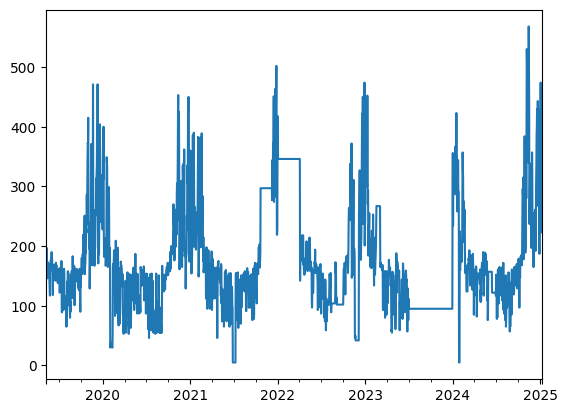

In [22]:
norm_aqi = new_data4['AQI']
norm_aqi.plot()

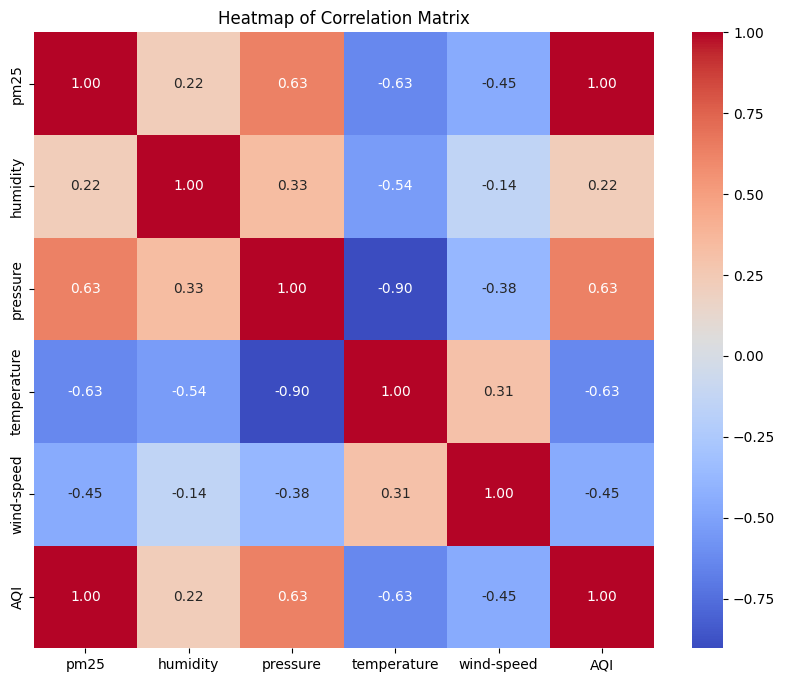

In [23]:
# Calculate the correlation matrix for numeric columns
corr = new_data4.corr(numeric_only=True)

# Create a heatmap using the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Correlation Matrix")
#file_name = "correlation_matrix.png"
#path = "/kaggle/working/"
#plt.savefig(path + file_name)
plt.show()

# 2. Machine Learning (without scaling)

## 2.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [24]:
new_data4.columns

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed', 'AQI'], dtype='object')

In [25]:
data = new_data4.copy()

In [26]:
data.head()

,pm25,humidity,pressure,temperature,wind-speed,AQI
2019-05-09,196.0,20.0,1003.0,33.0,2.3,196.0
2019-05-10,159.0,28.0,1004.0,32.0,3.6,159.0
2019-05-11,197.0,43.0,1007.0,29.0,3.0,197.0
2019-05-12,176.0,37.0,1006.0,31.0,2.5,176.0
2019-05-13,171.0,51.0,1005.0,28.0,2.5,171.0


In [27]:
num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
cat = data.select_dtypes(include=['object'])

print(num.columns)
print(cat.columns)

Index(['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed', 'AQI'], dtype='object')
Index([], dtype='object')


In [28]:
X = data[['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed']]

y = data['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1658, 5) (1658,) (415, 5) (415,)


In [29]:
# Preprocessor without scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['pm25', 'humidity', 'pressure', 'temperature', 'wind-speed'])
    ])
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

## 2.2. ML Model

In [30]:
def compare_and_save_models(X_train, X_test, y_train, y_test, preprocessor, metric='mse', save_dir='models'):
    
    
    # Initialize models
    models = {
        'knn': KNeighborsRegressor(n_neighbors=2),
        'random_forest': RandomForestRegressor(),
        'xgboost': XGBRegressor(objective='reg:squarederror'),
        'svr' : SVR(kernel='linear'),
        'neural_network': MLPRegressor(hidden_layer_sizes=(8,), activation='relu', 
                                     solver='adam', max_iter=2000, 
                                     learning_rate_init=0.0005)
    }
    
    # Dictionary to store results
    results = {}
    
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Train and evaluate each model
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('regressor', model)])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'r2_train': r2_score(y_train, y_pred_train),
            'r2_test': r2_score(y_test, y_pred_test),
            'rmse_train': sqrt(mean_squared_error(y_train, y_pred_train)),
            'rmse_test': sqrt(mean_squared_error(y_test, y_pred_test)),
            'mae_train': mean_absolute_error(y_train, y_pred_train),
            'mae_test': mean_absolute_error(y_test, y_pred_test),
            'mse_train': mean_squared_error(y_train, y_pred_train),
            'mse_test': mean_squared_error(y_test, y_pred_test)
        }
        
        results[name] = {
            'pipeline': pipeline,
            'metrics': metrics
        }
    
    # Determine best model based on specified metric
    metric_map = {
        'r2': 'r2_test',
        'rmse': 'rmse_test',
        'mae': 'mae_test',
        'mse': 'mse_test'
    }
    
    comparison_metric = metric_map[metric]
    
    if metric == 'r2':  # Only R² should use max, all others should use min
        best_model = max(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    else:  # For MSE, RMSE, MAE - lower is better
        best_model = min(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    
    # Save the best model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(save_dir, 
                             f'best_model_{best_model[0]}_{timestamp}.joblib')
    joblib.dump(best_model[1]['pipeline'], model_path)
    
    # Prepare return dictionary
    return_dict = {
        'best_model': best_model[0],
        'best_model_path': model_path,
        'model_performances': {name: results[name]['metrics'] 
                             for name in results.keys()}
    }
    
    return return_dict

In [31]:
# Get the results first
results = compare_and_save_models(
    X_train, X_test, y_train, y_test,
    preprocessor,
    metric='mse',
    save_dir='models'
)

In [32]:
# Print detailed results for all models
print("\nDetailed Model Performance Summary:")
print("-" * 50)

for model_name, performance in results['model_performances'].items():
    print(f"\n{model_name.upper()} Results:")
    print(f"R² score (train): {performance['r2_train']:.4f}")
    print(f"R² score (test): {performance['r2_test']:.4f}")
    print(f"RMSE (train): {performance['rmse_train']:.4f}")
    print(f"RMSE (test): {performance['rmse_test']:.4f}")
    print(f"MAE (train): {performance['mae_train']:.4f}")
    print(f"MAE (test): {performance['mae_test']:.4f}")
    print(f"MSE (train): {performance['mse_train']:.4f}")
    print(f"MSE (test): {performance['mse_test']:.4f}")

print("\n" + "=" * 50)
print(f"Best Model: {results['best_model']}")
print(f"Model saved at: {results['best_model_path']}")


Detailed Model Performance Summary:
--------------------------------------------------

KNN Results:
R² score (train): 0.9998
R² score (test): 0.9990
RMSE (train): 1.2491
RMSE (test): 3.0459
MAE (train): 0.7515
MAE (test): 1.2976
MSE (train): 1.5603
MSE (test): 9.2777

RANDOM_FOREST Results:
R² score (train): 1.0000
R² score (test): 0.9989
RMSE (train): 0.3918
RMSE (test): 3.0691
MAE (train): 0.0753
MAE (test): 0.3423
MSE (train): 0.1535
MSE (test): 9.4193

XGBOOST Results:
R² score (train): 1.0000
R² score (test): 0.9982
RMSE (train): 0.1387
RMSE (test): 4.0416
MAE (train): 0.0774
MAE (test): 0.8002
MSE (train): 0.0192
MSE (test): 16.3346

SVR Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.0467
RMSE (test): 0.0481
MAE (train): 0.0413
MAE (test): 0.0425
MSE (train): 0.0022
MSE (test): 0.0023

NEURAL_NETWORK Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.0933
RMSE (test): 0.4563
MAE (train): 0.0279
MAE (test): 0.0499
MSE (train): 0.

# 3 - Deep Learning Model(Without Scaling)

## 3.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [33]:
aqi_normal = new_data4.copy()

In [34]:
def new_data_to_X_y(new_data, window_size, train_pct, val_pct, test_pct):
    
    new_data_as_np = new_data.to_numpy()
    
    # Split features and target
    features = new_data_as_np[:, :-1]  # All columns except the last one
    target = new_data_as_np[:, -1]     # Only the AQI column
    
    # Split data based on percentages
    total_len = len(features)
    train_end = int(train_pct * total_len)
    val_end = train_end + int(val_pct * total_len)
    
    # Prepare train, val, and test splits for both features and target
    train_features = features[:train_end]
    train_target = target[:train_end]
    
    val_features = features[train_end:val_end]
    val_target = target[train_end:val_end]
    
    test_features = features[val_end:]
    test_target = target[val_end:]
    
    # Helper function to create X and y
    def create_X_y(feature_data, target_data):
        X, y = [], []
        for i in range(len(feature_data) - window_size):
            # Create sequence of all features
            sequence = feature_data[i:i + window_size]
            X.append(sequence)
            # Get the target AQI value
            y.append(target_data[i + window_size])
        return np.array(X), np.array(y)
    
    
    X_train, y_train = create_X_y(train_features, train_target)
    X_val, y_val = create_X_y(val_features, val_target)
    X_test, y_test = create_X_y(test_features, test_target)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [35]:
WINDOW_SIZE = 6
NUM_FEATURES = 5
train_pct = 0.8
val_pct = 0.1
test_pct = 0.1

(X_train1, y_train1), (X_val1, y_val1), (X_test1, y_test1) = new_data_to_X_y(
    aqi_normal, WINDOW_SIZE, train_pct, val_pct, test_pct
)

In [36]:
# shapes
print("Train shapes:", X_train1.shape, y_train1.shape)
print("Validation shapes:", X_val1.shape, y_val1.shape)
print("Test shapes:", X_test1.shape, y_test1.shape)

Train shapes: (1652, 6, 5) (1652,)
Validation shapes: (201, 6, 5) (201,)
Test shapes: (202, 6, 5) (202,)


##  3.2. DL Model

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

### LSTM(normal)

In [38]:
model5 = Sequential()
model5.add(InputLayer((6, 5)))  # 6 timestamps, 6 features
model5.add(LSTM(32, activation='relu', return_sequences=False))  # Single LSTM layer
model5.add(Dense(16, activation='relu')) 
model5.add(Dense(1, activation='linear'))  

cp5 = ModelCheckpoint('/kaggle/working/model5.keras', save_best_only=True)

model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])

model5.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp5])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 26060.1367 - root_mean_squared_error: 161.3384 - val_loss: 13651.7588 - val_root_mean_squared_error: 116.8407
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14295.9697 - root_mean_squared_error: 119.4932 - val_loss: 9060.1924 - val_root_mean_squared_error: 95.1850
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11064.1357 - root_mean_squared_error: 105.1446 - val_loss: 6860.1460 - val_root_mean_squared_error: 82.8260
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8780.2471 - root_mean_squared_error: 93.5487 - val_loss: 5470.7871 - val_root_mean_squared_error: 73.9648
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5851.7236 - root_mean_squared_error: 76.4231 - val_loss: 4418.6045 - val_root_mean_squared_error: 66.4726
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5753.3779 - root_mean_squared_error: 75.8084 - val_loss: 3558.9614 - val_root_mean_squared_error: 59.6570
E

In [39]:
from tensorflow.keras.models import load_model
model5 = load_model('/kaggle/working/model5.keras')

In [40]:
# Evaluate the model on the train data
train_result = model5.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 29.2183
Mean Squared Error (MSE): 1841.1896
Root Mean Squared Error (RMSE): 42.9091
R-squared (Accuracy): 0.7695


In [41]:
# Evaluate the model on the validation data
val_result = model5.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 25.6563
Mean Squared Error (MSE): 1745.0833
Root Mean Squared Error (RMSE): 41.7742
R-squared (Accuracy): 0.6863


In [42]:
# Evaluate the model on the test data
test_result = model5.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 43.7323
Mean Squared Error (MSE): 3816.3932
Root Mean Squared Error (RMSE): 61.7770
R-squared (Accuracy): 0.6524


In [43]:
train_predictions = model5.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,148.122421,172.0
1,164.155319,173.0
2,166.012619,163.0
3,166.298508,154.0
4,147.362610,171.0
...,...,...
1647,99.270355,95.0
1648,99.270355,95.0
1649,99.270355,95.0
1650,99.270416,95.0


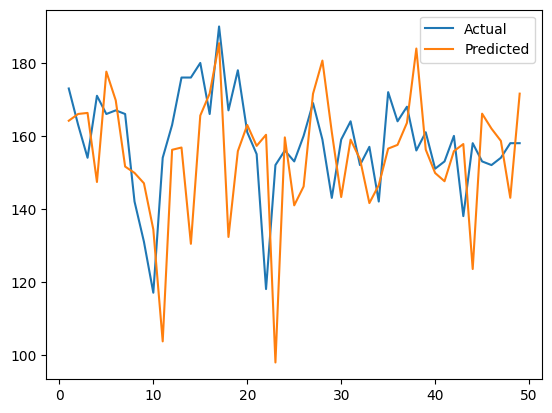

In [44]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [45]:
val_predictions = model5.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,99.270355,95.0
1,99.270355,95.0
2,99.270355,95.0
3,99.270355,95.0
4,99.270355,95.0
...,...,...
196,147.615952,157.0
197,147.615952,157.0
198,147.616486,157.0
199,147.616486,122.0


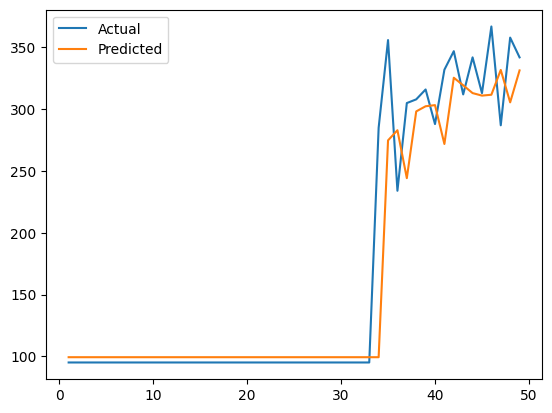

In [46]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [47]:
test_predictions = model5.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,96.951843,122.0
1,96.951843,122.0
2,96.951843,122.0
3,96.951843,122.0
4,96.951843,122.0
...,...,...
197,318.339417,294.0
198,301.019989,267.0
199,158.616516,223.0
200,310.835632,252.0


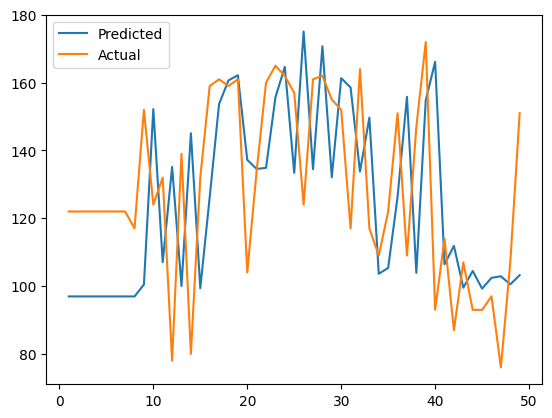

In [48]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

### Hybrid CNN + LSTM¶

In [49]:
model8 = Sequential()
model8.add(InputLayer((6, 5)))  # 6 timestamps, 6 features
model8.add(Conv1D(32, kernel_size=2, activation='relu'))  # 1D Convolutional Layer
model8.add(MaxPooling1D(pool_size=2))  # Max Pooling
model8.add(LSTM(64, activation='relu', return_sequences=False))  
model8.add(Dropout(0.3))  
model8.add(Dense(32, activation='relu'))  
model8.add(Dense(1, activation='linear'))  

cp8 = ModelCheckpoint('/kaggle/working/model8.keras', save_best_only=True)

model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])

model8.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp8])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 21222.1270 - root_mean_squared_error: 145.2220 - val_loss: 10423.8916 - val_root_mean_squared_error: 102.0975
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12083.0850 - root_mean_squared_error: 109.7481 - val_loss: 6390.4932 - val_root_mean_squared_error: 79.9406
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8882.6709 - root_mean_squared_error: 94.2388 - val_loss: 5248.4277 - val_root_mean_squared_error: 72.4460
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7708.6714 - root_mean_squared_error: 87.7856 - val_loss: 4423.8247 - val_root_mean_squared_error: 66.5118
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6830.4756 - root_mean_squared_error: 82.6039 - val_loss: 4298.9258 - val_root_mean_squared_error: 65.5662
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5933.9194 - root_mean_squared_error: 77.0154 - val_loss: 4037.7371 - val_root_mean_squared_error: 63.5432
Epo

In [50]:
from tensorflow.keras.models import load_model
model8 = load_model('/kaggle/working/model8.keras')

In [51]:
# Evaluate the model on the train data
train_result = model8.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 44.0203
Mean Squared Error (MSE): 3736.3937
Root Mean Squared Error (RMSE): 61.1260
R-squared (Accuracy): 0.5323


In [52]:
# Evaluate the model on the validation data
val_result = model8.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 43.3788
Mean Squared Error (MSE): 3762.6319
Root Mean Squared Error (RMSE): 61.3403
R-squared (Accuracy): 0.3236


In [53]:
# Evaluate the model on the test data
test_result = model8.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 51.5189
Mean Squared Error (MSE): 6307.2337
Root Mean Squared Error (RMSE): 79.4181
R-squared (Accuracy): 0.4256


In [54]:
train_predictions = model8.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,132.414581,172.0
1,157.047195,173.0
2,159.224304,163.0
3,141.988159,154.0
4,125.885735,171.0
...,...,...
1647,105.136795,95.0
1648,105.136795,95.0
1649,105.136795,95.0
1650,105.136787,95.0


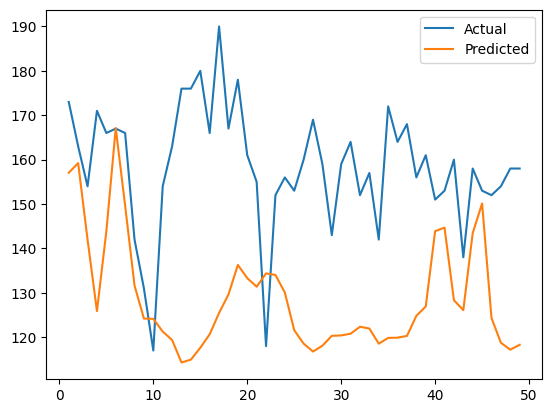

In [55]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [56]:
val_predictions = model8.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,105.136795,95.0
1,105.136795,95.0
2,105.136795,95.0
3,105.136795,95.0
4,105.136795,95.0
...,...,...
196,120.030327,157.0
197,120.030327,157.0
198,120.030319,157.0
199,120.030319,122.0


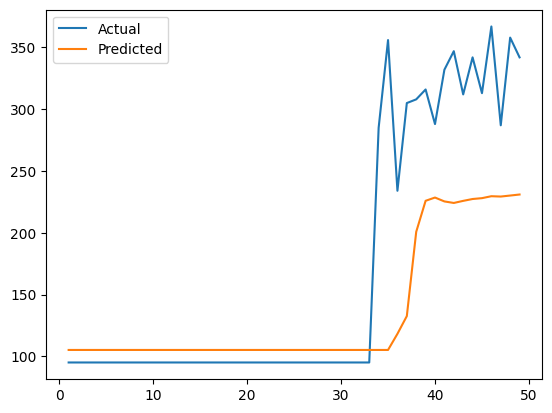

In [57]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [58]:
test_predictions = model8.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,110.767212,122.0
1,110.767212,122.0
2,110.767212,122.0
3,110.767212,122.0
4,110.767212,122.0
...,...,...
197,233.121048,294.0
198,239.616562,267.0
199,241.218292,223.0
200,237.347855,252.0


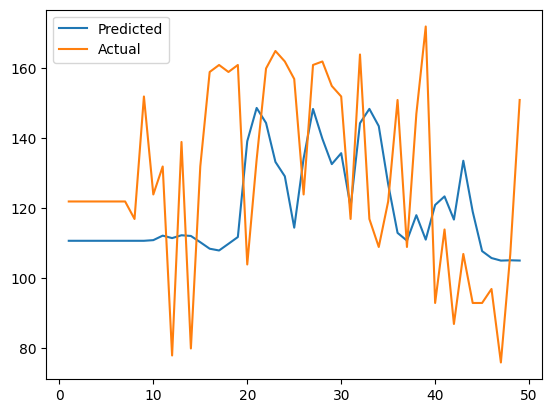

In [59]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

### Advanced Stacked GRU + Dense¶

In [60]:
model9 = Sequential()
model9.add(InputLayer((6, 5)))  # 6 timestamps, 6 features
model9.add(BatchNormalization())  # Normalize inputs
model9.add(GRU(128, activation='relu', return_sequences=True))  # GRU layer
model9.add(Dropout(0.3))  # Dropout for regularization
model9.add(GRU(64, activation='relu', return_sequences=False))  # Second GRU layer
model9.add(Dense(32, activation='relu'))  # Fully connected layer
model9.add(Dense(16, activation='relu'))  # Second dense layer
model9.add(Dense(1, activation='linear'))  # Output layer

cp9 = ModelCheckpoint('/kaggle/working/model9.keras', save_best_only=True)

model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])

model9.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp9])

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 40571.7461 - root_mean_squared_error: 201.3405 - val_loss: 33412.9336 - val_root_mean_squared_error: 182.7921
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 38992.9492 - root_mean_squared_error: 197.4161 - val_loss: 25971.8457 - val_root_mean_squared_error: 161.1578
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 37698.8906 - root_mean_squared_error: 194.1251 - val_loss: 664883.5625 - val_root_mean_squared_error: 815.4039
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 22157.7539 - root_mean_squared_error: 148.6007 - val_loss: 9952113.0000 - val_root_mean_squared_error: 3154.6970
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 10749.4424 - root_mean_squared_error: 103.6012 - val_loss: 2644812.2500 - val_root_mean_squared_error: 1626.2878
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7790.6426 - root_mean_squared_error: 88.2385 - val_loss: 476853.6562 - val_root_mea

In [61]:
from tensorflow.keras.models import load_model
model9 = load_model('/kaggle/working/model9.keras')

In [62]:
# Evaluate the model on the train data
train_result = model9.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 25.8692
Mean Squared Error (MSE): 1568.4740
Root Mean Squared Error (RMSE): 39.6040
R-squared (Accuracy): 0.8037


In [63]:
# Evaluate the model on the validation data
val_result = model9.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 26.4082
Mean Squared Error (MSE): 2400.2259
Root Mean Squared Error (RMSE): 48.9921
R-squared (Accuracy): 0.5685


In [64]:
# Evaluate the model on the test data
test_result = model9.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 39.0349
Mean Squared Error (MSE): 3378.7191
Root Mean Squared Error (RMSE): 58.1268
R-squared (Accuracy): 0.6923


In [65]:
train_predictions = model9.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Train Predictions,Actuals
0,170.476807,172.0
1,168.337540,173.0
2,160.539062,163.0
3,146.787338,154.0
4,138.664581,171.0
...,...,...
1647,96.488480,95.0
1648,96.488480,95.0
1649,96.488480,95.0
1650,96.488472,95.0


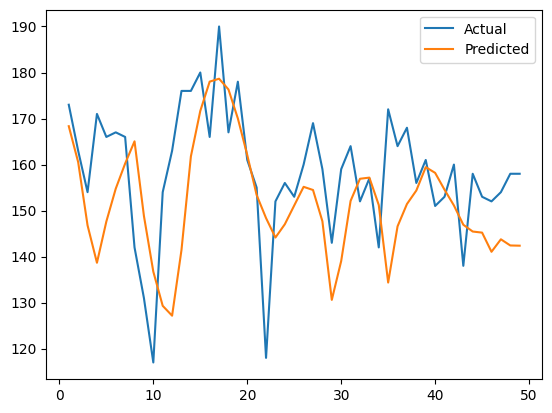

In [66]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [67]:
val_predictions = model9.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,96.488480,95.0
1,96.488480,95.0
2,96.488480,95.0
3,96.488480,95.0
4,96.488480,95.0
...,...,...
196,149.873062,157.0
197,149.873062,157.0
198,149.873093,157.0
199,149.873093,122.0


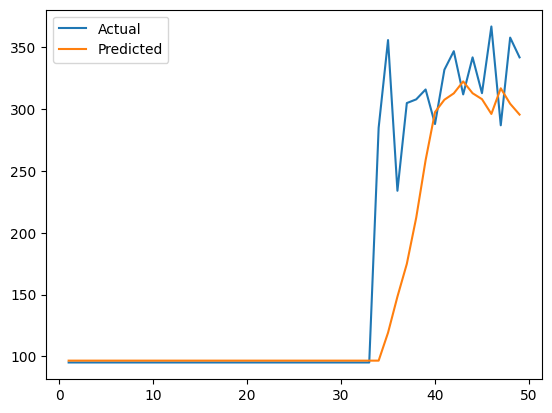

In [68]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [69]:
test_predictions = model9.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,123.756577,122.0
1,123.756577,122.0
2,123.756577,122.0
3,123.756577,122.0
4,123.756577,122.0
...,...,...
197,329.872772,294.0
198,284.336273,267.0
199,256.200653,223.0
200,251.724609,252.0


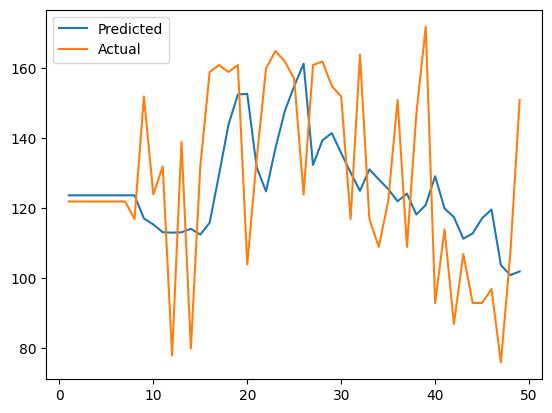

In [70]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

# 4. Load Model and export dataset

In [71]:
from joblib import load


# Load the model
model_path = '/kaggle/working/models/best_model_svr_20250128_025404.joblib'
model = load(model_path)

# Predict using the model
predictions = model.predict(data)

# Add predictions and location to the original DataFrame
data['Country_City'] = "Pakistan_Lahore"
data['predictions'] = predictions

# Function to classify AQI levels
def classify_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

# Apply AQI bucket classification to the predictions column
data['AQI Bucket'] = data['AQI'].apply(classify_aqi)

# Save the updated DataFrame to CSV
os.makedirs('/kaggle/working', exist_ok=True)

# Save to CSV
data.to_csv('/kaggle/working/pakistan_lahore_predictions.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/models/best_model_svr_20250128_025404.joblib'